## modeling, ARIMA

- **AR**: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.
- **I**: Integrated. The use of differencing of raw observations in order to make the time series stationary.
- **MA**: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

With the AR (auto regressive), the intention is to use the data already known to predict the future data.

$$
y_i = a_0 + \sum_{j=1}^p {a_j y_{i-j}} + \epsilon_i
$$

With the MA (moving average) is to use the error to predict the future data.

$$
y_i = \mu + \epsilon_i + \sum_{j=1}^q {b_j \epsilon_{i-j}}
$$

for ARIMA, have 3 parameters $(p,d,q)$, and 4 parameters $(P,D,Q,s)$ for seasonal component.  
$p$ is for the AR model, how many history data to be used to predict future data.  
$q$ is for the MA model, how many error count in for predicting future data.  
$d$ is for how many level of diffrencing, to make the data stationary.  
the $P,D,Q$ of seasonal component is similar. $s$ is cycle periods.

## Load dataset

In [ ]:
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.rcParams.update({'figure.figsize': (12,6),\
                     'figure.titlesize':16,\
                     'axes.titlesize':16,\
                     'axes.labelsize':14,\
                     'xtick.labelsize':14,\
                     'ytick.labelsize':14,
                    })

In [ ]:
import datetime
from statsmodels.tsa.seasonal import seasonal_decompose

file_path = pathlib.Path('D:/Edu/data_resource/monthly-car-sales.csv')
carsales = pd.read_csv(file_path, parse_dates=['Month'], index_col='Month', date_parser=lambda x: pd.to_datetime(x))

carsales_decomp = seasonal_decompose(carsales)
carsales_trend = carsales_decomp.trend
carsales_seasonal = carsales_decomp.seasonal
carsales_residual = carsales_decomp.resid

### deciding the parameter  

Rules can be used when deciding (p, q, d) values:  
- look at an autocorrelation graph of the data (will help if Moving Average (MA) model is appropriate)
- look at a partial autocorrelation graph of the data (will help if AutoRegressive (AR) model is appropriate)
- look at extended autocorrelation chart of the data (will help if a combination of AR and MA are needed)
- try Akaike's Information Criterion (AIC) on a set of models and investigate the models with the lowest AIC values
- try the Schwartz Bayesian Information Criterion (BIC) and investigate the models with the lowest BIC values

Let's remove the season decomposition and keeps trend and residual.

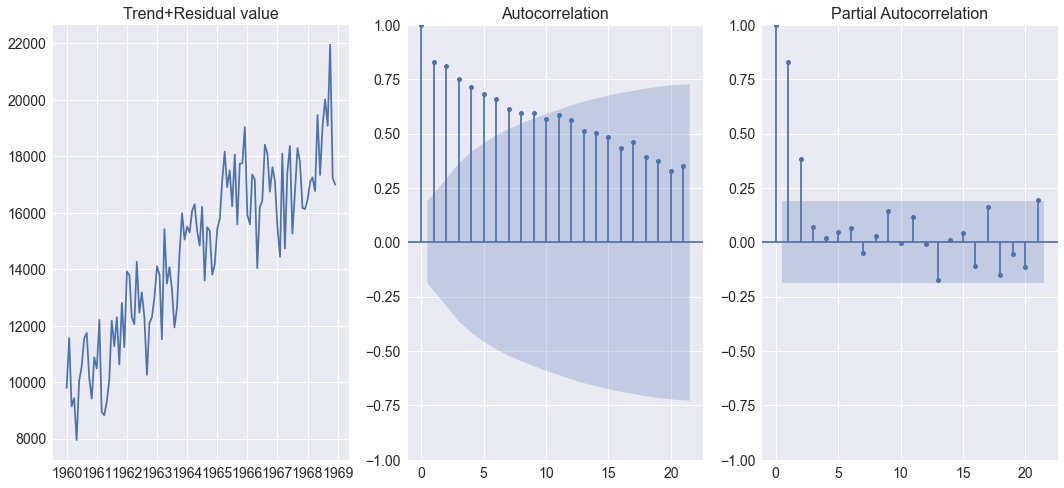

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1,3,figsize=(18,8))
trend_residual = carsales.sub(carsales_seasonal, axis=0)
axes[0].plot(carsales.index, trend_residual['Sales'])
axes[0].set_title('Trend+Residual value')
plot_acf(trend_residual['Sales'].dropna(),ax=axes[1])
plot_pacf(trend_residual['Sales'].dropna(),ax=axes[2],method='ywm')

plt.show()

It is not stationary.

Get the difference again. We already know that the seasonal data periods = 12. so do difference as follow: (diff12 is the data removed seasonal part. diff12_diff1 is the data we make and try to find the non-seasonal part parameter $p,d,q$)

In [130]:
diff12 = carsales.diff(periods=12)
diff12_diff1 = diff12.diff(periods=1)
diff12_diff1

,Sales
Month,
1960-01-01,NaN
1960-02-01,NaN
1960-03-01,NaN
1960-04-01,NaN
1960-05-01,NaN
...,...
1968-08-01,-516.0
1968-09-01,-2501.0
1968-10-01,3368.0


In [132]:
do_adf_test(diff12_diff1.dropna())

ADF Test Statistic	-3.345096536305219
P-Value 		0.01297913109073938
# Lags Used 		11
# Observations Used 	83
Critical Value (1%) 	 -3.5117123057187376
Critical Value (5%) 	 -2.8970475206326833
Critical Value (10%) 	 -2.5857126912469153


It is stationary series.

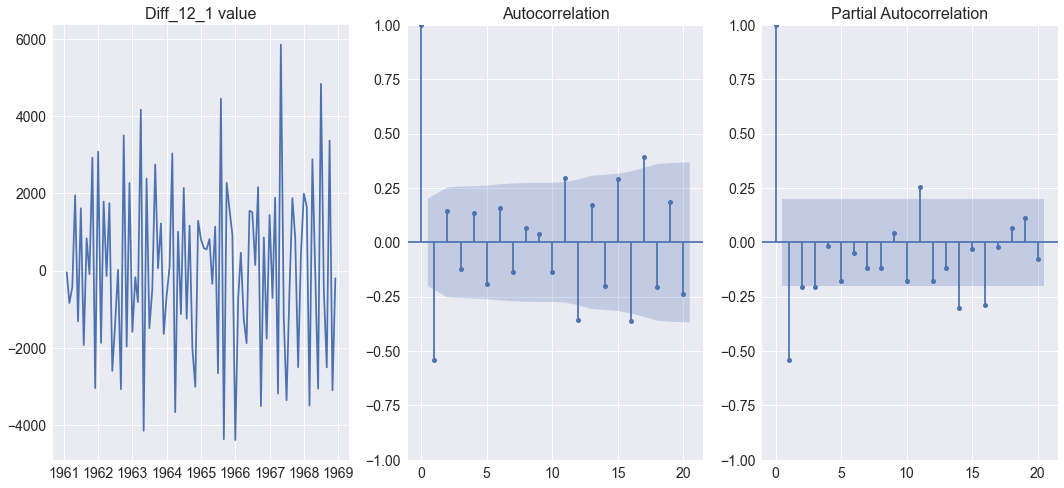

In [137]:
fig, axes = plt.subplots(1,3,figsize=(18,8))

axes[0].plot(diff1.index, diff12_diff1['Sales'])
axes[0].set_title('Diff_12_1 value')
plot_acf(diff12_diff1['Sales'].dropna(),ax=axes[1])
plot_pacf(diff12_diff1['Sales'].dropna(),ax=axes[2],method='ywm')

plt.show()

So for non-seasonal model, p=1, q=1, d=1. (the autocorrelation at position 1 is obviously outside of range. so select q=1. for partial autocorrelation also position 1 is obviously outside of range, so select p=1. here we are using 1 periods difference so d=1.)  


We go back to diff12 data try to find the parameter $(P,D,Q,s)$ for seasonal part.

In [138]:
do_adf_test(diff12.dropna())

ADF Test Statistic	-3.644396602406014
P-Value 		0.004966833586579756
# Lags Used 		11
# Observations Used 	84
Critical Value (1%) 	 -3.510711795769895
Critical Value (5%) 	 -2.8966159448223734
Critical Value (10%) 	 -2.5854823866213152


from the augmated Dickey-Fuller test, the diff(12) which remove the seasonal data, (keeps trend+residual), is also stationary.

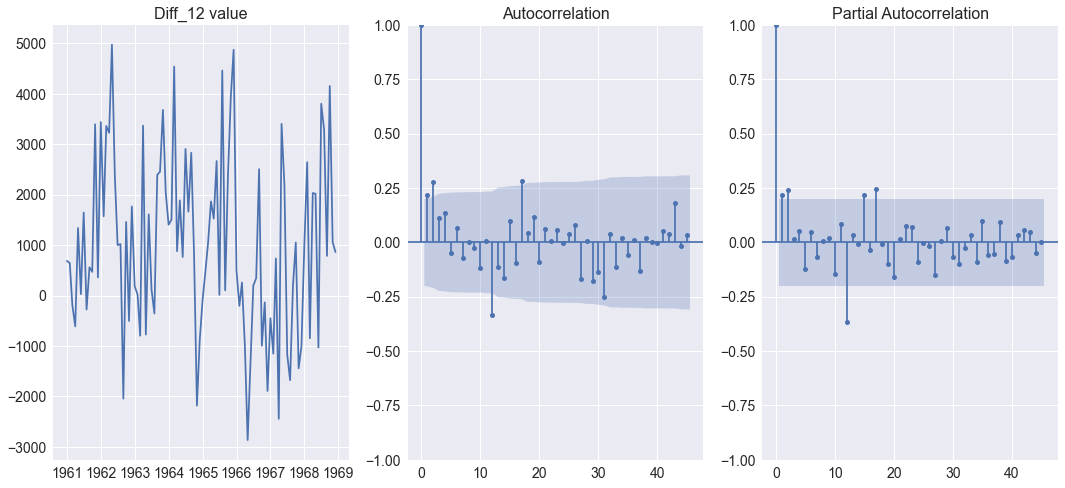

In [141]:
fig, axes = plt.subplots(1,3,figsize=(18,8))

axes[0].plot(diff1.index, diff12['Sales'])
axes[0].set_title('Diff_12 value')
plot_acf(diff12['Sales'].dropna(),ax=axes[1], lags=45)
plot_pacf(diff12['Sales'].dropna(),ax=axes[2],method='ywm', lags=45)

plt.show()

ACF and PACF both has spikes at 0, negative at 12. This 2 obviously outside of the noise range.  
so for seasonal data, parameter: P=1, Q=1, D=1, S=12.

In [155]:
from statsmodels.tsa.arima.model import ARIMA
from pandas.tseries.offsets import DateOffset

model = ARIMA(carsales, order=(1, 1, 1), seasonal_order=(1,1,1,12), freq='MS', missing='drop')
arimares = model.fit()
print(arimares.summary())

C:\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


                                    SARIMAX Results                                     
Dep. Variable:                            Sales   No. Observations:                  108
Model:             ARIMA(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -837.667
Date:                          Thu, 30 Sep 2021   AIC                           1685.335
Time:                                  03:05:12   BIC                           1698.104
Sample:                              01-01-1960   HQIC                          1690.494
                                   - 12-01-1968                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2093      0.123      1.696      0.090      -0.033       0.451
ma.L1         -0.8889      0.064    -13.983      0.

In [156]:
print(arimares.aic, arimares.bic, arimares.hqic)

1685.3346637985833 1698.1040482565859 1690.4944531410868


In [157]:
predict_res = arimares.predict(start='1960-02-01', end='1970-12-01')
predict_res

1960-02-01     4766.550122
1960-03-01     6883.371010
1960-04-01     9584.328082
1960-05-01    11909.704089
1960-06-01    12957.150545
                  ...     
1970-08-01    17536.678405
1970-09-01    15934.109726
1970-10-01    21539.952380
1970-11-01    18899.444694
1970-12-01    16375.279271
Freq: MS, Name: predicted_mean, Length: 131, dtype: float64

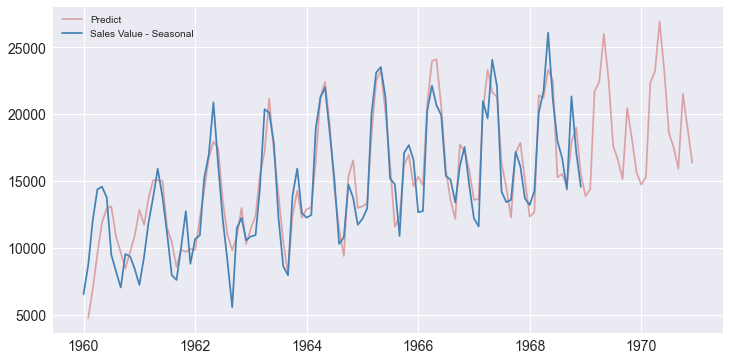

In [158]:
plt.plot(pd.date_range(start='1960-02-01', end='1970-12-01', freq='MS'), predict_res, color='IndianRed', alpha=0.5, label='Predict')
plt.plot(carsales,color='SteelBlue', label='Sales Value - Seasonal')
plt.legend(loc='best')

The forcast outside the sample scope, looks ok. the trend seems slow down even peak show decreasing, something need further investigate in the model.